In [1]:
# check the cars that have a disabled parking permit
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/dpelleg/miniconda/lib/python3.10/site-packages')
from statsmodels.stats.proportion import proportions_ztest

# do I need this? how to persist the change in path?


In [2]:
def count_repeated_chars(string, k):
    count = 0
    for i in range(len(string)-(k-1)):
        if string[i:i+k] == string[i]*k:
            count += 1
    return count

def is_palindrome(string):
    return string == string[::-1]

def has_numeric_sequence_3(string):
    for i in range(len(string)-2):
        if int(string[i])+1 == int(string[i+1]) and int(string[i+1])+1 == int(string[i+2]):
            return True
    return False

def has_numeric_sequence_3_rev(string):
    return has_numeric_sequence_3(string[::-1])

def count_distinct_chars(string):
    return len(set(string))

def distinct_chars_under(s, n):
    return count_distinct_chars(s) <= n

def distinct_chars_over(s, n):
    return count_distinct_chars(s) >= n

def count_repeated_sequences(string, seq_length):
    count = 0
    for i in range(len(string) - seq_length + 1):
        if string[i:i+seq_length] in string[i+seq_length:]:
            count += 1
    return count

scoremap = {
    lambda s: count_repeated_chars(s, 2): 1,
    lambda s: count_repeated_chars(s, 3): 1,
    lambda s: count_repeated_chars(s, 4): 1,
    is_palindrome: 5,
    has_numeric_sequence_3 : 2,
    has_numeric_sequence_3_rev : 2,
    lambda s: distinct_chars_under(s, 1): 10,
    lambda s: distinct_chars_under(s, 2): 5,
    lambda s: distinct_chars_under(s, 3): 2,
#    lambda s: distinct_chars_over(s, 5): 2,
#    lambda s: distinct_chars_over(s, 6): 5,
#    lambda s: distinct_chars_over(s, 7): 6,
#    lambda s: distinct_chars_over(s, 8): 8,
    lambda s: count_repeated_sequences(s, 2): 2,
    lambda s: count_repeated_sequences(s, 3): 3,
}

def score(s):
    ret = 0
    for idx, (f, mult) in enumerate(scoremap.items()):
        result = f(s)
        ret += mult*int(result)
    return ret

In [3]:
def read_file(fname, enc='iso8859-8'):
    fd = open(fname, encoding=enc, errors='replace')
    df = pd.read_csv(fd, sep='|')
    return df

def add_model(df):
    df['model'] = df.apply(lambda x: '_'.join([x[y] for y in ['tozeret_cd', 'degem_cd', 'shnat_yitzur', 'sug_degem']]), axis=1)

In [4]:
# source : https://data.gov.il/dataset/private-and-commercial-vehicles/resource/053cea08-09bc-40ec-8f7a-156f0677aff3?inner_span=True

#df = pd.read_csv('data/rechev-small.csv', encoding='iso-8859-1', sep='|')
cars = read_file('data/rechev.csv')

for c in ['mispar_rechev', 'degem_cd', 'tozeret_cd', 'shnat_yitzur']:
    cars[c] = cars[c].astype(str)

add_model(cars)

cars['score'] = cars['mispar_rechev'].apply(score)

In [5]:
# source: https://data.gov.il/dataset/rechev-tag-nachim
disabled = pd.read_csv('data/disabled-plates.csv', sep='|')
disabled.columns = ['mispar_rechev', 'taarich_tag', 'sug_tag']
for c in ['mispar_rechev']:
    disabled[c] = disabled[c].astype(str)
#disabled['score'] = disabled['mispar_rechev'].apply(score)

In [6]:
# merge dataframes
merged = pd.merge(cars, disabled, on='mispar_rechev', how='left', indicator=True)

# create boolean column indicating if record exists in Y
merged['disabled'] = merged['_merge'] == 'both'
merged.drop(columns=['_merge'], inplace=True)
# there are about 14,000 records which are only in the disabled set, not much to do about them

df = merged

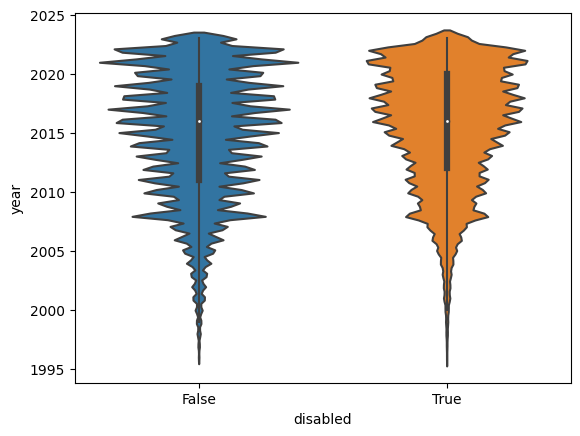

In [7]:
df['year'] = pd.to_numeric(df['shnat_yitzur'], errors='ignore')
sns.violinplot(x='disabled', y='year', data=df)

plt.show()

In [8]:
# source : https://data.gov.il/dataset/mehir_yevuan
# add model prices
fname = 'data/vehicle_cost.csv'
fd = open(fname, encoding='utf-8', errors='replace')
prices = pd.read_csv(fd, sep='|', low_memory=False)

for c in ['degem_cd', 'tozeret_cd', 'shnat_yitzur']:
    prices[c] = prices[c].astype(str)
for c in ['mehir']:
    prices[c] = pd.to_numeric(prices[c], errors='coerce')

add_model(prices)
prices_ = prices.copy()
prices = prices[['model', 'mehir']]
df = pd.merge(left=df, right=prices, on='model')

In [9]:
cols =['ramat_eivzur_betihuty', 'kvutzat_zihum', 'score', 'year', 'mehir']
df.groupby('disabled')[cols].agg(['mean', 'count'])

ramat_eivzur_betihuty          kvutzat_zihum              score  \
                          mean    count          mean    count      mean   
disabled                                                                   
False                 3.179328  1124144     12.176920  2627924  1.099667   
True                  3.261944   204139     12.310894   433399  1.144823   

                          year                   mehir           
            count         mean    count           mean    count  
disabled                                                         
False     2971939  2015.007726  2971939  151532.581552  2971939  
True       477073  2015.614654   477073  162143.177459   477073

In [10]:
def ztest_proportions(df, population, test):
    xtab=pd.crosstab(df[population], df[test])
    se, pval = proportions_ztest(xtab[True].to_list(), xtab.sum(axis=1).to_list())
    return pval

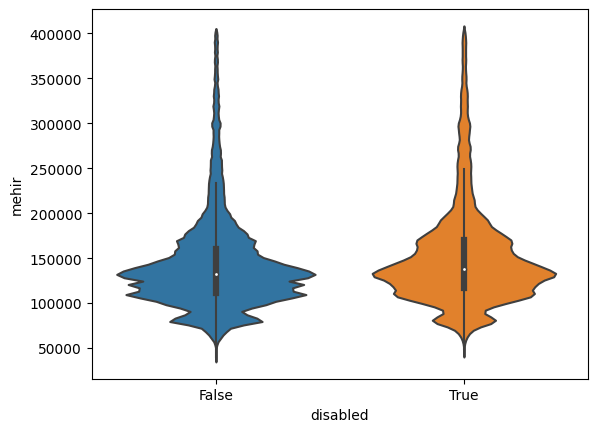

In [11]:
sns.violinplot(x='disabled', y='mehir', data=df.query('mehir < 4e5'))
plt.show()

In [12]:
# read detailed tech specs on each model
# source: https://data.gov.il/dataset/degem-rechev-wltp
models = read_file('data/models.csv', enc='utf-8')
#models.columns

In [13]:
cols = ['tozeret_cd', 'tozeret_nm', 'shnat_yitzur',
       'degem_cd', 'nefah_manoa',
       'mishkal_kolel', 'gova',
       'hege_koah_ind',
       'automatic_ind',
       'koah_sus',
       'mispar_moshavim', 'kinuy_mishari', 'sug_degem',
       'hanaa_nm',
       ]
models = models[cols]

In [14]:
for c in ['degem_cd', 'tozeret_cd', 'shnat_yitzur']:
    models[c] = models[c].astype(str)

add_model(models)

In [15]:
df_before = df.copy()

In [16]:
merged = pd.merge(left=df_before, right=models.drop(columns=['kinuy_mishari', 'sug_degem', 'tozeret_nm']), on='model', how='left', indicator=True)
merged.drop(columns=['_merge'], inplace=True)

In [17]:
df=merged

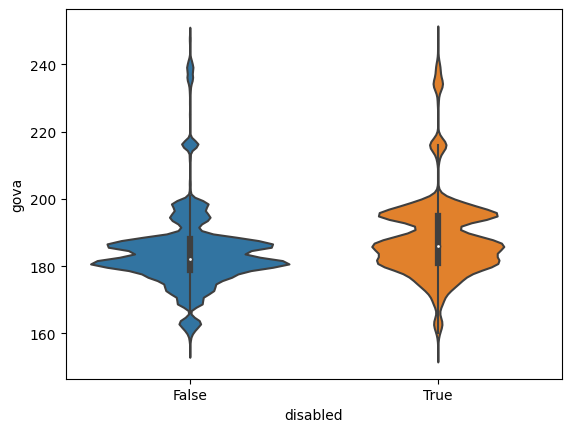

In [30]:
sns.violinplot(x='disabled', y='gova', data=merged.query('gova > 150 and gova < 250'))
#plt.legend(title="הכנ", labels=["No", "Yes"])
plt.show()

In [31]:
df['mehir'].quantile(0.9)

221900.0

In [32]:
df['koah_sus'].quantile(0.95)

204.0

In [35]:
# check proportions of news cars with disabled permits
df['new'] = df['year'] > 2020

# check proportions of luxury cars with disabled permits
df['luxury'] = df['mehir'] > df['mehir'].quantile(0.9)

# check proportions of fancy-plate cars with disabled permits
df['coolnum'] = df['score'] > df['score'].quantile(0.9)

# check proportions of tall cars with disabled permits
df['tall'] = df['gova'] > 220

# check proportions of short cars with disabled permits
df['short'] = (df['gova'] < 160) & (df['gova'] > 0)

# check proportions of muscle cars with disabled permits
df['muscle'] = df['koah_sus'] > df['koah_sus'].quantile(0.95)

# Tesla
df['tesla'] = df['tozeret_nm'].str.contains("טסלה")

# people-mover
df['seven'] = df['mispar_moshavim'] >= 7

# huge pickup type
df.loc[:, 'monster'] = df.eval('gova > 180 and hanaa_nm == "4X4" and nefah_manoa > 2000 and mispar_moshavim < 7')

# more features
features = ['automatic_ind', 'hege_koah_ind']
for c in features:
    df[c] = df[c] == 1

for f in ['new', 'luxury', 'coolnum', 'tall', 'short', 'muscle', 'tesla', 'seven', 'monster'] + features:
    pv = ztest_proportions(df, 'disabled', f)
    print(f'Testing {f}, p-val:{pv:.3f}')
    print(pd.crosstab(df['disabled'], df[f], normalize='index'))
    print(pd.crosstab(df['disabled'], df[f]))
    print('-----')

Testing new, p-val:0.000
new          False      True
disabled                    
False     0.813117  0.186883
True      0.803879  0.196121
new         False    True
disabled                 
False     2416535  555404
True       383509   93564
-----
Testing luxury, p-val:0.000
luxury       False      True
disabled                    
False     0.903605  0.096395
True      0.877555  0.122445
luxury      False    True
disabled                 
False     2685460  286479
True       418658   58415
-----
Testing coolnum, p-val:0.000
coolnum      False      True
disabled                    
False     0.953321  0.046679
True      0.947935  0.052065
coolnum     False    True
disabled                 
False     2833211  138728
True       452234   24839
-----
Testing tall, p-val:0.012
tall         False      True
disabled                    
False     0.998683  0.001317
True      0.998824  0.001176
tall        False  True
disabled               
False     2968026  3913
True       476512   561
--

In [20]:
top_muscle = df[df['muscle'] & df['disabled']]['model'].value_counts()#.head(20)
top_muscle = pd.DataFrame(data={'model' : top_muscle.index, 'count' : top_muscle.values})
#top_muscle = pd.DataFrame(top_muscle.reset_index(drop=True))

In [21]:
pd.merge(top_muscle, models, on='model', how='left')[['count', 'model','tozeret_nm', 'kinuy_mishari', 'koah_sus']][:10]

,count,model,tozeret_nm,kinuy_mishari,koah_sus
0,156,481_302_2022_P,יונדאי קוריאה,IONIQ5,217
1,131,885_335_2017_P,קיה קוריאה,CARNIVAL,276
2,108,481_299_2022_P,יונדאי קוריאה,IONIQ5,217
3,96,239_279_2022_P,"ג'יפ ארהב""",GRAND CHEROKEE,286
4,90,156_121_2010_P,ביואיק ארהב,LACROSSE,255
5,89,885_453_2019_P,קיה קוריאה,CARNIVAL,276
6,88,961_43_2015_P,"שברולט ארהב""",MALIBU LT,259
7,87,1327_2_2021_P,טסלה סין,MODEL 3,325
8,84,156_151_2011_P,ביואיק ארהב,LACROSSE,280
9,84,1327_405_2022_P,טסלה סין,MODEL 3,283


In [22]:
models_ = read_file('data/models.csv', enc='utf-8')

In [23]:
# vans : mercedes sprinter and 319, peagut boxer, folkswagon crafter and transporter, ford transit, toyota sienna
models_.query('kinuy_mishari == "MG3"')[['kinuy_mishari', 'tozeret_nm', 'gova']]#.drop_duplicates()

,kinuy_mishari,tozeret_nm,gova
31611,MG3,מ.ג סין,NaN
31612,MG3,מ.ג סין,NaN
31613,MG3,מ.ג סין,NaN
31614,MG3,מ.ג סין,NaN
31615,MG3,מ.ג סין,NaN
31616,MG3,מ.ג סין,NaN
31617,MG3,מ.ג סין,NaN
31627,MG3,מ.ג סין,NaN
31628,MG3,מ.ג סין,NaN
31630,MG3,מ.ג סין,NaN


In [24]:
models_.columns

Index(['sug_degem', 'tozeret_cd', 'tozeret_nm', 'tozeret_eretz_nm', 'tozar',
       'degem_cd', 'degem_nm', 'shnat_yitzur', 'kvuzat_agra_cd', 'nefah_manoa',
       'mishkal_kolel', 'gova', 'hanaa_cd', 'hanaa_nm', 'mazgan_ind',
       'abs_ind', 'kariot_avir_source', 'mispar_kariot_avir', 'hege_koah_ind',
       'automatic_ind', 'halonot_hashmal_source', 'mispar_halonot_hashmal',
       'halon_bagg_ind', 'galgaley_sagsoget_kala_ind', 'argaz_ind', 'merkav',
       'ramat_gimur', 'delek_cd', 'delek_nm', 'mispar_dlatot', 'koah_sus',
       'mispar_moshavim', 'bakarat_yatzivut_ind', 'kosher_grira_im_blamim',
       'kosher_grira_bli_blamim', 'sug_tkina_cd', 'sug_tkina_nm',
       'sug_mamir_cd', 'sug_mamir_nm', 'technologiat_hanaa_cd',
       'technologiat_hanaa_nm', 'kamut_CO2', 'kamut_NOX', 'kamut_PM10',
       'kamut_HC', 'kamut_HC_NOX', 'kamut_CO', 'kamut_CO2_city',
       'kamut_NOX_city', 'kamut_PM10_city', 'kamut_HC_city', 'kamut_CO_city',
       'kamut_CO2_hway', 'kamut_NOX_hway', '

In [25]:
models_.query('gova > 200 and hanaa_nm == "4X4" and nefah_manoa > 2000 and mispar_moshavim < 7')[['tozeret_nm','kinuy_mishari', 'mispar_moshavim']].drop_duplicates()

,tozeret_nm,kinuy_mishari,mispar_moshavim
136,דימלרקריזלר-גר,313 CDI,6
987,גיפ-ישראל,סופה,4
2189,טויוטה יפן,לנד קרוזר_ארוך,0
3465,מרצדס בנץ גרמנ,SPRINTER,3
3499,מרצדס בנץ גרמנ,SPRINTER,2
4944,פולקסווגן גרמנ,TRANSPORTER,3
4968,פולקסווגן גרמנ,TRANSPORTER,2
5123,פולקסווגן גרמנ,TRNSPORTER,3
6663,פולקסווגן גרמנ,LT,1
6725,"פורד ארהב""",F 150,5


In [26]:
models[models['tozeret_nm'].str.contains("טסלה")].kinuy_mishari.value_counts()
#models.query('kinuy_mishari == "MODEL 3"')

MODEL 3    895
MODEL Y    150
MODEL X     80
MODEL S     56
Name: kinuy_mishari, dtype: int64